In [6]:
import torch
from torch import nn
from torchvision import transforms
from torchvision import models
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import copy
from copy import deepcopy
import sys
import os
import pandas as pd
import numpy as np
import random
from pathlib import Path

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # dead kernel for matplotlib

In [7]:
sys.path.append('../segmentation')

In [8]:
from UNet import UNet

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [10]:
metadata = pd.read_csv('../doby_meta.csv')
metadata = metadata[metadata['subject_id'] < 16000000]
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4198 entries, 0 to 4197
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject_id      4198 non-null   int64 
 1   study_id        4198 non-null   int64 
 2   dicom_id        4198 non-null   object
 3   DicomPath       4198 non-null   object
 4   edema_severity  4198 non-null   int64 
 5   normal          4198 non-null   int64 
 6   CHF             4198 non-null   bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 233.7+ KB


In [11]:
ORIG_BASE_PATH = '../physionet.org/files/mimic-cxr-jpg/2.0.0'

In [12]:
TRANSFORMS = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
class Dataset(Dataset):
    def __init__(self, metadata, orig_base_path, transform=None):
        self.metadata = metadata
        self.orig_base_path = Path(orig_base_path)
        self.transform = transform

    def __getitem__(self, idx):
        x_path = self.metadata.loc[idx, 'DicomPath']
        x_orig_path = self.orig_base_path / Path(x_path)
        
        x_orig = Image.open(x_orig_path).convert('L').resize((224, 224))

        y = self.metadata.loc[idx, 'normal']

        if self.transform:
            x = self.transform(x_orig)

        return x, y

    def __len__(self):
        return self.metadata['normal'].count()

In [14]:
ds = Dataset(metadata, ORIG_BASE_PATH, TRANSFORMS)

In [15]:
ds_size = len(ds)
train_size = int(ds_size * 0.8)
test_size = ds_size - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size], generator=torch.manual_seed(42))

In [16]:
class customDenseNet(nn.Module):
    def __init__(self):
        super(customDenseNet, self).__init__()
        self.model = models.densenet121()
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.linear = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

In [17]:
segmentation_model = UNet(channel=1)
segmentation_model.load_state_dict(torch.load('../segmentation/parameters/unet_best_f1_model_state.pt', map_location=device))

classification_model = customDenseNet()
classification_model.load_state_dict(torch.load('../classification/densenet_parameters/tune_best_f1_model_state.pt', map_location=device))

<All keys matched successfully>

In [18]:
transform = transforms.ToTensor()

In [32]:
def inference(X, model1, model2, toTensor):
    with torch.no_grad():
        input = X.unsqueeze(dim=0)
        segmentation_tensor = model1(input)
        segmentation_tensor = segmentation_tensor.squeeze()
        segmentation_img = to_pil_image(segmentation_tensor)
        original_img = to_pil_image(X)

        seg_mask = np.array(segmentation_img)
        seg_mask = np.where(seg_mask > 128, 1, 0)
        lung_part_img = np.array(original_img) * seg_mask
        lung_part_img = np.array(lung_part_img)
        original_img = original_img.filter(ImageFilter.GaussianBlur(1))

        blending_img = Image.blend(original_img, segmentation_img, 0.2)
        blending_img = ImageOps.equalize(blending_img)
        blending_tensor = toTensor(blending_img).unsqueeze(dim=0)

        predicted = model2(blending_tensor)
        return segmentation_img, lung_part_img, original_img, blending_img, predicted.item()

In [34]:
import time
from IPython.display import clear_output

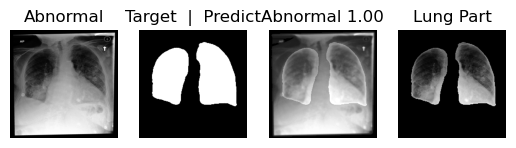

In [35]:
classification_model.eval()
segmentation_model.eval()

x, y = test_ds[0]
seg_img, lung_part_img, orig_img, blend_img, pred = inference(x, segmentation_model, classification_model, transform)

plt.subplot(1, 4, 1)
plt.title('Abnormal' if y >= 0.5 else 'Normal')
plt.imshow(to_pil_image(x), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Target  |  Predict')
plt.imshow(seg_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title(f'Abnormal {pred:.2f}' if pred >= 0.5 else f'Normal {pred:.2f}')
plt.imshow(blend_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Lung Part')
plt.imshow(lung_part_img, cmap='gray')
plt.axis('off')

plt.show()

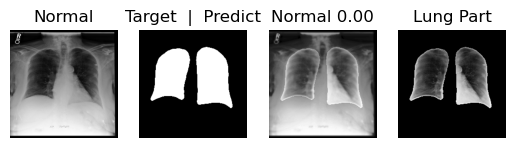

In [36]:
classification_model.eval()
segmentation_model.eval()

x, y = test_ds[3]
seg_img, lung_part_img, orig_img, blend_img, pred = inference(x, segmentation_model, classification_model, transform)

plt.subplot(1, 4, 1)
plt.title('Abnormal' if y >= 0.5 else 'Normal')
plt.imshow(to_pil_image(x), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Target  |  Predict')
plt.imshow(seg_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title(f'Abnormal {pred:.2f}' if pred >= 0.5 else f'Normal {pred:.2f}')
plt.imshow(blend_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Lung Part')
plt.imshow(lung_part_img, cmap='gray')
plt.axis('off')

plt.show()